In [1]:
import plotly.express as px

import pandas as pd
import numpy as np
import os, sys, pickle, warnings, functools, pathlib, json
from tqdm import tqdm
from matplotlib import pyplot as plt

from pathos.threading import ThreadPool
import editdistance
import multiprocess


In [2]:
def remove_UNK_and_take_subset(df_train):
    df_nounk = df_train[df_train['tcra']!='UNK']
    print("df_nounk.value_counts() \n\t ", df_nounk.sign.value_counts().to_dict())
    print("df_nounk.drop_duplicates('tcrb') \n\t ", df_nounk.drop_duplicates('tcrb').sign.value_counts().to_dict())
    return df_nounk

@functools.lru_cache()
def get_df(datapath):
    return pd.DataFrame(pickle.load(open(datapath, "rb"))).assign(datapath=datapath)

def get_df_from_path(p_list):
    return pd.concat([get_df(d) for d in p_list]).reset_index(drop=True)

def split_and_get_first(a):
    if ',' in a:
        a = a.split(',')[0]
    return a



def func_multithread(
        xs,
        func,
        n_threads=os.cpu_count()-1
):
    pool = ThreadPool(nodes=n_threads)
    params = xs #[(x, y) for x in xs for y in ys]
    result = pool.map(lambda p: func(p), params)
    return result

In [3]:
TCELLTYPE_MAP = {'MHCI':'CD8', 'MHCII':'CD4', 'CD4,CD8':'CD8', 'CD8':'CD8', 'CD4':'CD4'}

RCOLS = ['tcra', 'tcrb', 't_cell','peptide', 'data_type', 'tcra:tcrb', 'sign']

p_list = [
    f"../.././external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
    f"../.././external_data/ERGO-II/Samples/mcpas_train_samples.pickle", 
    "../.././external_data/ERGO-II/Samples/vdjdb_test_samples.pickle",
    "../.././external_data/ERGO-II/Samples/mcpas_test_samples.pickle",
         ]

df_ergo = get_df_from_path(p_list)
df_ergo = remove_UNK_and_take_subset(df_ergo)
df_ergo['tcra:tcrb'] = df_ergo['tcra'] + ':' + df_ergo['tcrb']
df_ergo['data_type'] = df_ergo.datapath.str.split('/').apply(lambda x: x[-1])

print("df_ergo.shape with no t-cell-type", df_ergo.shape, end=' -> ')
df_ergo = df_ergo.dropna(subset=['t_cell_type'])
df_ergo['t_cell'] = df_ergo['t_cell_type'].map(TCELLTYPE_MAP)
print(df_ergo.shape, )

jem_20211327_tables3 = pd.read_csv('../data/jem_20211327_tables3.csv')
for c in ['CDR3.alpha', 'CDR3.beta', ]:
    jem_20211327_tables3 = jem_20211327_tables3.dropna(subset=[c])
jem_20211327_tables3['tcra:tcrb'] = jem_20211327_tables3['CDR3.alpha'] + ':' + jem_20211327_tables3['CDR3.beta']

jem_20211327_tables3 = jem_20211327_tables3.rename(columns={'CDR3.alpha':'tcra','CDR3.beta':'tcrb'})

jem_20211327_tables3['data_type'] = 'jem_20211327_tables3'

jem_20211327_tables3['t_cell'] = 'CD4'
jem_20211327_tables3['sign'] = np.nan
jem_20211327_tables3['peptide'] = np.nan

## df_all 
df_all = pd.concat([jem_20211327_tables3[RCOLS], df_ergo[RCOLS]])

print("df_all.shape", df_all.shape)

df_nounk.value_counts() 
	  {0: 146088, 1: 29123}
df_nounk.drop_duplicates('tcrb') 
	  {0: 15387, 1: 3775}
df_ergo.shape with no t-cell-type (175211, 14) -> (169015, 15)
df_all.shape (170811, 7)


In [4]:
df_all.loc[df_all['tcra:tcrb'].duplicated()]

print("df_all.shape with no duplicates", df_all.shape, end=' -> ')
df_all = df_all[~df_all['tcra:tcrb'].duplicated()] #.data_type.value_counts()

print("", df_all.shape, )


print("df_all.shape with sampled", df_all.shape, end=' -> ')

df_all = pd.concat(
    [df_all[df_all['data_type']=='vdjdb_train_samples.pickle'], # .sample(frac=0.6, random_state=0),
     df_all[df_all['data_type']!='vdjdb_train_samples.pickle']
    ])

print("", df_all.shape, )

df_all.shape with no duplicates (170811, 7) ->  (24088, 7)
df_all.shape with sampled (24088, 7) ->  (24088, 7)


In [5]:
# df_all.to_parquet('s3://sg-playground-kkoyama-temp/tcrpred/vdjdb_seq_samples.parquet')

In [6]:
DICT_DIS = {}

def calcdis(s1,s2):
    if (s1,s2) in DICT_DIS:
        return DICT_DIS[(s1,s2)]
    else:
        d = editdistance.eval(s1, s2)
        DICT_DIS[(s1, s2)] = d
        DICT_DIS[(s2, s1)] = d
        return d

def to_distance_map(seqs):
    ret = {}
    for s in seqs:
        func = functools.partial(calcdis, s2=s)
#         with multiprocess.Pool(os.cpu_count()-1) as p:
#             dict_list = p.map(func, seqs)
        dict_list = func_multithread(seqs, func)
        ret[s] = dict_list
    return ret


def to_distance_map_single(seqs):
    ret = {}
    for s in tqdm(seqs):
        func = functools.partial(calcdis, s2=s)
        dict_list = [func(s) for s in seqs]
        ret[s] = dict_list
    return ret

In [7]:
df_all['tcraXtcrb'] = df_all['tcra'] + 'P'*100 + df_all['tcrb']

In [8]:
"""# !rm tcr_all_distmat.txt tcr_all_aligned.txt tcr_all_fasta.txt """

'# !rm tcr_all_distmat.txt tcr_all_aligned.txt tcr_all_fasta.txt '

In [9]:
%%time

ofile = open("tcr_p100_fasta.txt", "w")
for i, seq in enumerate(df_all.tcraXtcrb.tolist()):
    ofile.write(">" + str(i) + "\n" + seq + "\n")
ofile.close()

## ##### time
## - 500 4
## - 1000 7.2
## - 5000 46.5
## - 10000 133?
## - 20000 195.5?
## - 24088 621

if not os.path.exists('tcr_p100_aligned.txt'):
    os.system("~/Downloads/clustalo -i tcr_p100_fasta.txt -o tcr_p100_aligned.txt --full --distmat-out=tcr_p100_distmat.txt")


CPU times: user 20 ms, sys: 5.82 ms, total: 25.8 ms
Wall time: 23.7 ms


In [10]:
!head -n 100 tcr_p100_aligned.txt

>0
-------------------C-AVENYGQNFVFPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPP----PPPP---PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPPPCASS---YDS---------PTEAFF---------------
>1
------CA---------A--G-GSGGYQKVTFPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPPPPP----PPP---PPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPPPCASSLA---DRN-TE--------A--FF------------
>2
-----------C------ALSELGGATNKLIFPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPPPPP----PPP--PPPPPPP-PPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPPPCASSL-VGLPS--S-----YNSPLHF--------------
>3
------------------CAASHTNTGNQFYFPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPP----PPPPP---PPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPPPCASSSPGKSSYNE------QFF------------------
>4
---------C----LV----GDGTGTASKLTFPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPPPPP----PPP---PPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPPPPPPPPPPCASSWGVG--STE------------AFF------------
>5
-------------------CAEMEGGSYIPTFPPPPPPPPPPPPPPPPPPPPPPPPPPPP
PPPPPPPPPPP

In [15]:
!head -n 2 tcr_p100_distmat.txt

24088
0     0.000000 0.648000 0.672000 0.656000 0.688000 0.672000 0.632000 0.632000 0.648000 0.648000 0.648000 0.680000 0.664000 0.648000 0.664000 0.640000 0.704000 0.648000 0.672000 0.640000 0.648000 0.640000 0.648000 0.656000 0.640000 0.648000 0.664000 0.672000 0.672000 0.664000 0.672000 0.632000 0.640000 0.680000 0.596774 0.656000 0.672000 0.648000 0.664000 0.688000 0.680000 0.664000 0.648000 0.632000 0.664000 0.648000 0.664000 0.637097 0.634146 0.629032 0.664000 0.632000 0.648000 0.704000 0.640000 0.648000 0.648000 0.648000 0.656000 0.624000 0.648000 0.704000 0.656000 0.664000 0.616000 0.648000 0.656000 0.640000 0.640000 0.648000 0.648000 0.664000 0.648000 0.664000 0.664000 0.648000 0.656000 0.640000 0.664000 0.624000 0.600000 0.640000 0.637097 0.656000 0.656000 0.637097 0.648000 0.640000 0.664000 0.656000 0.656000 0.680000 0.680000 0.664000 0.656000 0.688000 0.640000 0.624000 0.632000 0.640000 0.624000 0.640000 0.648000 0.648000 0.632000 0.632000 0.648000 0.629032 0.640000 0.64800

In [12]:
%%time

import multiprocess as mp

if not os.path.exists('tcr_p100_distmat.parquet'):
    pd_reader = pd.read_csv('tcr_p100_distmat.txt',sep=' 0', skiprows=[0], header=None, 
                                  chunksize=1000
                                 ) #.tail(2)

    with mp.Pool(os.cpu_count()-1) as p:
        df_list = p.map(lambda x:x, pd_reader)
        
        
    df_distmat = pd.concat(df_list)
    df_distmat = df_distmat.iloc[:,1:]
    df_distmat.columns = df_distmat.columns.astype(str)
    df_distmat.to_parquet('tcr_p100_distmat.parquet')
else:
    df_distmat = pd.read_parquet('tcr_p100_distmat.parquet')

CPU times: user 8.4 s, sys: 18.2 s, total: 26.6 s
Wall time: 9.17 s


In [13]:
import umap
reducer = umap.UMAP(metric='precomputed', random_state=42)
embedding = reducer.fit_transform(df_distmat)
print('embedding.shape', embedding.shape)


df_emb = pd.DataFrame(embedding, columns=['umap0','umap1'])
df_emb['tcraXtcrb'] = df_all.tcraXtcrb.tolist()

df_emb = pd.merge(df_emb, df_all, on=['tcraXtcrb'], how='left')

/Users/kyoheikoyama/.pyenv/versions/miniconda3-latest/envs/tcrpred/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


embedding.shape (24088, 2)


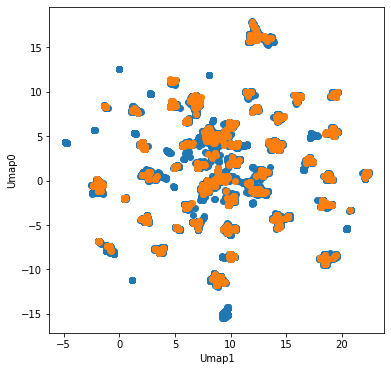

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(df_emb.query('data_type!="jem_20211327_tables3"').umap0, 
            df_emb.query('data_type!="jem_20211327_tables3"').umap1)
plt.scatter(df_emb.query('data_type=="jem_20211327_tables3"').umap0, 
            df_emb.query('data_type=="jem_20211327_tables3"').umap1)
# plt.title('Pep')
plt.xlabel('Umap1')
plt.ylabel('Umap0')
plt.show()

In [16]:

# fig = px.scatter(df_emb, x="umap0", y="umap1",
#                  color='data_type', symbol='t_cell', opacity=0.51,
# #                  hover_name="country", hover_data=["continent", "pop"]
#                  title='TCR distribution'
#                 )

# fig.show()


In [17]:

# fig = px.scatter(df_emb.sample(600), x="umap0", y="umap1",
#                  color='data_type', symbol='t_cell', opacity=0.51,
# #                  hover_name="country", hover_data=["continent", "pop"]
#                  title='TCR distribution (600 TCRs sampled)'
#                 )

# fig.show()


In [18]:

# fig = px.scatter(df_emb, x="umap0", y="umap1",
#                  color='t_cell', 
#                  opacity=0.51,
#                 )

# fig.show()

In [19]:
df_emb

,umap0,umap1,tcraXtcrb,tcra,tcrb,t_cell,peptide,data_type,tcra:tcrb,sign
0,19.035690,-2.698593,CAVENYGQNFVFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CAVENYGQNFVF,CASSYDSPTEAFF,CD8,GPGHKARVL,vdjdb_train_samples.pickle,CAVENYGQNFVF:CASSYDSPTEAFF,0.0
1,17.057007,2.504281,CAAGGSGGYQKVTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CAAGGSGGYQKVTF,CASSLADRNTEAFF,CD8,AVFDRKSDAK,vdjdb_train_samples.pickle,CAAGGSGGYQKVTF:CASSLADRNTEAFF,0.0
2,10.607302,4.176024,CALSELGGATNKLIFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CALSELGGATNKLIF,CASSLVGLPSSYNSPLHF,CD8,ELAGIGILTV,vdjdb_train_samples.pickle,CALSELGGATNKLIF:CASSLVGLPSSYNSPLHF,0.0
3,14.354987,3.523889,CAASHTNTGNQFYFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CAASHTNTGNQFYF,CASSSPGKSSYNEQFF,CD8,KLGGALQAK,vdjdb_train_samples.pickle,CAASHTNTGNQFYF:CASSSPGKSSYNEQFF,1.0
4,4.618884,11.295615,CLVGDGTGTASKLTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CLVGDGTGTASKLTF,CASSWGVGSTEAFF,CD8,KLGGALQAK,vdjdb_train_samples.pickle,CLVGDGTGTASKLTF:CASSWGVGSTEAFF,0.0
...,...,...,...,...,...,...,...,...,...,...
24083,16.825672,2.086212,CAGSGGYQKVTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CAGSGGYQKVTF,CPSPLVGGGRF,CD4,LPRRSGAAGA,mcpas_test_samples.pickle,CAGSGGYQKVTF:CPSPLVGGGRF,0.0
24084,12.206594,-1.322600,CAASGGSNYKLTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CAASGGSNYKLTF,CAWGVLFIGRGVGDYGYTF,CD8,GILGFVFTL,mcpas_test_samples.pickle,CAASGGSNYKLTF:CAWGVLFIGRGVGDYGYTF,1.0
24085,16.820766,2.233039,CALGELSSGGYQKVTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CALGELSSGGYQKVTF,CASSSLGQGAPEAF,CD8,RYPLTFGWCF,mcpas_test_samples.pickle,CALGELSSGGYQKVTF:CASSSLGQGAPEAF,1.0
24086,-0.500445,-7.973754,CAAGITFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...,CAAGITF,CASSFRDRGNYAEQF,CD8,SYIPSAEKI,mcpas_test_samples.pickle,CAAGITF:CASSFRDRGNYAEQF,1.0


In [20]:

# fig = px.scatter(df_emb, x="umap0", y="umap1",
# #                  color='data_type', 
#                  color='data_type', 
#                  opacity=0.51,
                 
# #                  hover_name="country", hover_data=["continent", "pop"]
#                 )

# fig.show()


In [21]:
df_all[df_all.data_type!='jem_20211327_tables3'].sign.value_counts() / ((df_all.data_type!='jem_20211327_tables3').sum())


0.0    0.800375
1.0    0.199625
Name: sign, dtype: float64

In [20]:
# temp = df_emb.dropna(subset=['sign']).copy()
# temp['sign'] = temp['sign'].astype(bool)
# fig = px.scatter(temp, x="umap0", y="umap1",
#                  color='sign', 
#                  opacity=0.51,
#                 )

# fig.show()


In [ ]:
a = df_distmat.values
values = a[np.triu(a, k=1)!=0]

pd.Series(values).plot.hist(bins=30, title='tcr-tcr distance')

In [ ]:
df_emb.data_type.unique()

In [ ]:
df_vdjdb = pd.concat([
    df_emb.query('data_type=="vdjdb_train_samples.pickle"'),
    df_emb.query('data_type=="vdjdb_test_samples.pickle"'),
])

df_jem = pd.concat([
    df_emb.query('data_type=="jem_20211327_tables3"'),
])

In [ ]:
df_vdjdb[['tcra:tcrb', 'tcra','tcrb']].nunique()

In [ ]:
df_jem[['tcra:tcrb', 'tcra','tcrb']].nunique()

In [ ]:
df_vdjdb[df_vdjdb['tcra:tcrb'].isin(df_jem['tcra:tcrb'])]

In [ ]:
df_vdjdb[df_vdjdb['tcra'].isin(df_jem['tcra'])]

In [ ]:
df_vdjdb[df_vdjdb['tcrb'].isin(df_jem['tcrb'])]